# AIPI 590 - XAI | Assignment #02
### Description
### Your Name: Wilson Tseng

#### Assignment 2 - Adversarial Patches:
[GitHub Link](https://github.com/smilewilson1999/XAI/tree/main/Assignment%202%20-%20Adversarial%20Patches)


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Y6KTn8zPjOVJSzH5ufsPWkGG0KoZmG0G?usp=sharing)

## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "XAI" # Change to your repo name
git_path = 'https://github.com/smilewilson1999/XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment 2 - Adversarial Patches'
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'XAI'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 1), reused 15 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 21.65 MiB | 33.34 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/XAI/Assignment 2 - Adversarial Patches
'Duke AI XAI template.ipynb'


#### Using environment variables in Google Colab

In Google Colab, locate the key button on the left side of the screen. You can enter in any environment variables or API keys here and they will remain private.

Then add the environment variables to your notebook using the code below.

Make sure to document in your notebook if you are using API keys and how to get them (ie share a link for documentation to get a Hugging Face API Key if you are using Hugging Face)

In [ ]:
# Install required libraries:
!pip install torch torchvision foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00


In [3]:
!pip install torch torchvision adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from google.colab import files

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 載入預訓練的ResNet50模型
# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True).to(device)
model.eval()

# 定義圖像預處理
# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 載入ImageNet類別標籤
# Load ImageNet class labels
imagenet_classes = requests.get('https://raw.githubusercontent.com/AIPI-590-XAI/Duke-AI-XAI/main/adversarial-ai-example-notebooks/imagenet_classes.txt').text.splitlines()

# 定義對抗性補丁類
# Define adversarial patch class
class AdversarialPatch(nn.Module):
    def __init__(self, patch_size):
        super(AdversarialPatch, self).__init__()
        self.patch = nn.Parameter(torch.rand(3, patch_size, patch_size))

    def forward(self, x):
        return self.patch

# 創建對抗性補丁
# Create adversarial patch
patch_size = 200  # 增加補丁大小 # Increase patch size
adv_patch = AdversarialPatch(patch_size).to(device)

# 定義損失函數和優化器
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(adv_patch.parameters(), lr=0.05)

# 定義PGD攻擊
# Define PGD attack
def pgd_attack(image, epsilon, data_grad, alpha):
    perturbed_image = image.clone().detach() + alpha * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, image - epsilon, image + epsilon)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# 訓練對抗性補丁
# Train adversarial patch
def train_adversarial_patch(target_class, original_class, num_iterations=1000, epsilon=0.3, alpha=0.01):
    for i in range(num_iterations):
        optimizer.zero_grad()

        # 生成補丁
        # Generate patch
        patch = adv_patch(None)

        # 創建一個新的張量
        # Create a new tensor
        image = torch.ones(1, 3, 224, 224, requires_grad=True, device=device)

        # 將補丁應用到圖像中心，使用alpha混合
        # Apply patch to the center of the image using alpha blending
        y = (224 - patch_size) // 2
        x = (224 - patch_size) // 2
        mask = torch.ones_like(patch) * 0.8  # 80% 的補丁強度 # 80% patch intensity
        image.data[0, :, y:y+patch_size, x:x+patch_size] = image.data[0, :, y:y+patch_size, x:x+patch_size] * (1 - mask) + patch * mask

        # 對圖像進行分類
        # Classify the image
        output = model(image)

        # 計算損失（鼓勵目標類，抑制原始類）
        # Calculate loss (encourage target class, suppress original class)
        target_loss = criterion(output, torch.tensor([target_class]).to(device))
        original_loss = -torch.log_softmax(output, dim=1)[0, original_class]
        diversity_loss = -torch.sum(torch.log_softmax(output, dim=1) * torch.softmax(output, dim=1))
        loss = target_loss + 0.5 * original_loss + 0.1 * diversity_loss

        # 反向傳播
        # Backpropagation
        loss.backward()

        # 收集數據梯度
        # Collect data gradients
        data_grad = image.grad.data

        # 呼叫PGD攻擊
        # Call PGD attack
        perturbed_image = pgd_attack(image, epsilon, data_grad, alpha)

        # 更新補丁
        # Update patch
        with torch.no_grad():
            adv_patch.patch.data = perturbed_image.data[0, :, y:y+patch_size, x:x+patch_size].clone()

        if (i + 1) % 100 == 0:
            print(f'Iteration [{i+1}/{num_iterations}], Loss: {loss.item():.4f}')

    return adv_patch.patch.detach()

# 在目標圖像上應用補丁
# Apply patch to target image
def apply_patch(image_path, patch):
    original_image = Image.open(image_path).convert('RGB')
    image_tensor = transforms.ToTensor()(original_image)

    # 將補丁應用到圖像中心，使用alpha混合
    # Apply patch to the center of the image using alpha blending
    _, h, w = image_tensor.shape
    y = (h - patch_size) // 2
    x = (w - patch_size) // 2
    mask = torch.ones_like(patch) * 0.8  # 80% 的補丁強度 # 80% patch intensity
    image_tensor[:, y:y+patch_size, x:x+patch_size] = image_tensor[:, y:y+patch_size, x:x+patch_size] * (1 - mask) + patch * mask

    return transforms.ToPILImage()(image_tensor)

# 測試帶有補丁的圖像
# Test patched image
def test_patched_image(image):
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)

    _, predicted_idx = torch.max(output, 1)
    return imagenet_classes[predicted_idx.item()]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


Please upload an electric guitar image:


Saving Electronic_Guitar.jpg to Electronic_Guitar.jpg
Uploaded image: Electronic_Guitar.jpg
Target class: paddlewheel
Iteration [100/1000], Loss: 39.1907
Iteration [200/1000], Loss: 38.6283
Iteration [300/1000], Loss: 38.2803
Iteration [400/1000], Loss: 40.7219
Iteration [500/1000], Loss: 41.8328
Iteration [600/1000], Loss: 39.3678
Iteration [700/1000], Loss: 39.7527
Iteration [800/1000], Loss: 41.8967
Iteration [900/1000], Loss: 41.9184
Iteration [1000/1000], Loss: 36.4604


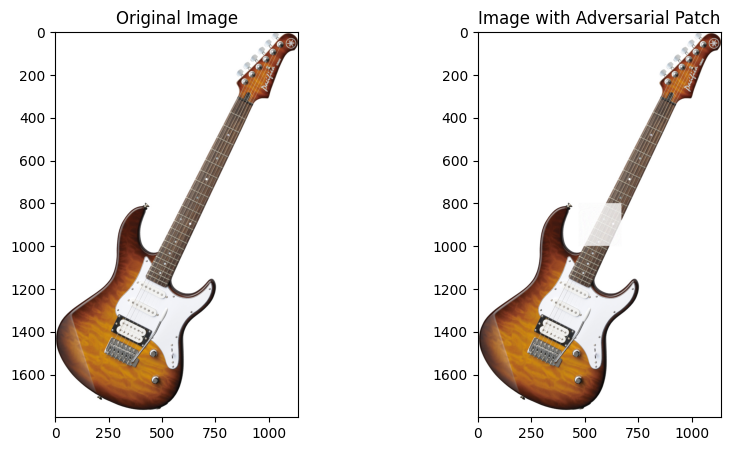

Original image classified as: electric guitar
Patched image classified as: electric guitar


In [5]:
# Main
print("Please upload an electric guitar image:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"Uploaded image: {image_path}")

electric_guitar_index = imagenet_classes.index("electric guitar")
target_class = np.random.choice([i for i in range(len(imagenet_classes)) if i != electric_guitar_index])
target_class_name = imagenet_classes[target_class]
print(f"Target class: {target_class_name}")

trained_patch = train_adversarial_patch(target_class=target_class, original_class=electric_guitar_index)
save_image(trained_patch, 'adversarial_patch.png')

patched_image = apply_patch(image_path, trained_patch)
patched_image.save('patched_image.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(Image.open(image_path))
ax1.set_title('Original Image')
ax2.imshow(patched_image)
ax2.set_title('Image with Adversarial Patch')
plt.show()

print(f"Original image classified as: {test_patched_image(Image.open(image_path))}")
print(f"Patched image classified as: {test_patched_image(patched_image)}")